In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

In [ ]:
#Генерация данных
def generate_data(N, d):
  noise_std = 0.1
  X = np.random.randn(N, d)
  w = np.random.randn(d)
  y = torch.FloatTensor(X) @ torch.FloatTensor(w).t()
  y += torch.randn_like(y) * noise_std
  y = y.tolist()
  return X, y

In [ ]:
#Разделение данных на N машин и приведение к тензорам
def separate_data(lst, num_cores):
  result = []
  size_per_core = len(lst) // num_cores
  size_last_core = size_per_core + len(lst) % num_cores
  if num_cores > 1:
    for i in range(num_cores - 1):
      result.append(lst[i:(i+1) * size_per_core])
  else: i = 0
  result.append(lst[(i*size_per_core + 1):])
  for i in range(len(result)):
    result[i] = torch.FloatTensor(result[i])
    result[i].requires_grad = True
  return result

In [ ]:
#Функция для усреднения весов после прохождения эпохи
def avg_w(w):
  d = w[0].shape[0]  #размер тензора
  avg = np.zeros(d)
  for el in w:
    for i in range(len(el.tolist())):
      avg[i] += el.tolist()[i]
  for j in range(len(avg)):
    avg[j] /= len(w)
  result = []
  for i in range(len(w)):
    result.append(avg)
    result[i] = torch.FloatTensor(result[i])
    result[i].requires_grad = True
  return result

In [ ]:
def model(x, w):
  return x @ w.t()

In [ ]:
def MSE(orig, predicted):
  diff = predicted - orig
  return torch.sum(diff * diff) / diff.numel()

In [ ]:
def learning_func(X, w, y):
  optimizer = torch.optim.SGD([w], lr=0.01)
  y_predicted = model(X, w)
  loss = MSE(y_predicted, y)
  loss.backward(retain_graph=True)
  optimizer.step()
  optimizer.zero_grad()
  return loss

In [ ]:
N = 100000
d = 1
noise_std = 0.1
num_machines = 5 #количество компов
X_orig, y_orig = generate_data(N, d)
X = separate_data(X_orig, num_machines)
y = separate_data(y_orig, num_machines)
X_s = torch.FloatTensor(X_orig)
X_s.requires_grad = True
y_s = torch.FloatTensor(y_orig)
y_s.requires_grad = True
w = []
w_orig = np.random.randn(d)
w_s = torch.FloatTensor(w_orig)
w_s.requires_grad = True
for i in range(num_machines):
  w.append(w_orig)
  w[i] = torch.FloatTensor(w[i])
  w[i].requires_grad = True

In [ ]:
#Параллельная модель
num_epochs = 100
time_sum = 0
for i in range(num_epochs):
  epoch_loss = 0
  #Параллельность
  for j in range(num_machines):
    time_start = time.time()
    epoch_loss += learning_func(X[j], w[j], y[j])
    time_sum += time.time() - time_start
  epoch_loss /= num_machines
  #Усреднение весов
  w = avg_w(w)
  if(i + 1) % 10 == 0:
    print(f'epoch: {i + 1}, avg_loss = {epoch_loss.tolist():.4f}')
print("Время обучения параллельной модели: %s сек" % (time_sum / num_machines))

epoch: 10, avg_loss = 0.0104
epoch: 20, avg_loss = 0.0103
epoch: 30, avg_loss = 0.0102
epoch: 40, avg_loss = 0.0102
epoch: 50, avg_loss = 0.0102
epoch: 60, avg_loss = 0.0101
epoch: 70, avg_loss = 0.0101
epoch: 80, avg_loss = 0.0101
epoch: 90, avg_loss = 0.0101
epoch: 100, avg_loss = 0.0101
Время обучения параллельной модели: 0.08768906593322753 сек


In [ ]:
optimizer = torch.optim.SGD([w_s], lr=0.01)

In [ ]:
#Обычная модель
#Обучение
num_epochs = 100
time_start = time.time()
for i in range(num_epochs):
    y_predicted = model(X_s, w_s)
    loss = MSE(y_predicted, y_s)
    loss.backward(retain_graph=True)
    optimizer.step()
    optimizer.zero_grad()

    if(i + 1) % 10 == 0:
      print(f'epoch: {i + 1}, loss = {loss:.4f}')
print("Время обучения обычной модели: %s сек" % (time.time() - time_start))

epoch: 10, loss = 1.1792
epoch: 20, loss = 0.7887
epoch: 30, loss = 0.5286
epoch: 40, loss = 0.3554
epoch: 50, loss = 0.2400
epoch: 60, loss = 0.1632
epoch: 70, loss = 0.1121
epoch: 80, loss = 0.0780
epoch: 90, loss = 0.0553
epoch: 100, loss = 0.0402
Время обучения обычной модели: 0.18718218803405762 сек


In [ ]:
#Склеиваем данные обратно в один тензор
y_to_plt, X_to_plt, y_pred_to_plt = [], [], []
for i in range(num_machines):
  y_to_plt.extend(y[i].tolist())
  X_to_plt.extend(X[i].tolist())
  y_pred_to_plt.extend(model(X[i], w[i]).tolist())

y_to_plt = torch.FloatTensor(y_to_plt)
X_to_plt = torch.FloatTensor(X_to_plt)
y_pred_to_plt = torch.FloatTensor(y_pred_to_plt)

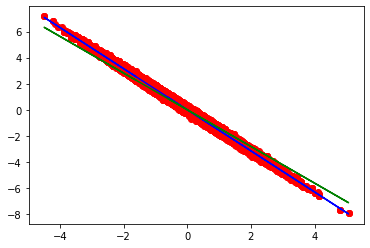

In [ ]:
plt.plot(X_to_plt.detach().numpy(), y_to_plt.detach().numpy(), 'ro')
plt.plot(X_to_plt.detach().numpy(), y_pred_to_plt.detach().numpy(), 'b')
plt.plot(X_s.detach().numpy(), y_predicted.detach().numpy(), 'g')
plt.show()